In [1]:
%matplotlib inline
from nilearn import datasets, image
from nilearn.image import index_img
from nilearn.input_data import NiftiMasker
import numpy as np
import pandas as pd
from nilearn.mass_univariate import permuted_ols
import matplotlib.pyplot as plt
from scipy.stats import t

/Users/taylor/Documents/tsalo/nilearn/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
haxby_dataset = datasets.fetch_haxby(subjects=[2])

# print basic information on the dataset
print('Mask nifti image (3D) is located at: %s' % haxby_dataset.mask)
print('Functional nifti image (4D) is located at: %s' % haxby_dataset.func[0])

Mask nifti image (3D) is located at: /Users/taylor/nilearn_data/haxby2001/mask.nii.gz
Functional nifti image (4D) is located at: /Users/taylor/nilearn_data/haxby2001/subj2/bold.nii.gz


In [3]:
labels = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
conditions = labels['labels']
categories = conditions.unique()
conditions_encoded = np.zeros_like(conditions)
for c, category in enumerate(categories):
    conditions_encoded[conditions == category] = c

sessions = labels['chunks']
condition_mask = conditions.isin(['face', 'house'])
conditions_encoded = conditions_encoded[condition_mask]
print(conditions_encoded)

[2 2 2 2 2 2 2 2 2 5 5 5 5 5 5 5 5 5 2 2 2 2 2 2 2 2 2 5 5 5 5 5 5 5 5 5 2
 2 2 2 2 2 2 2 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 5 5 5 5 5 5 5 5 5 2 2 2 2 2 2 2 2 2 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 5 5 5 5 5 5 5 5 5 2 2 2 2
 2 2 2 2 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 2 2 2 2 2 2 2 2 5 5 5 5 5
 5 5 5 5 2 2 2 2 2 2 2 2 2 5 5 5 5 5 5 5 5 5 2 2 2 2 2 2 2 2 2]


In [4]:
mask_filename = haxby_dataset.mask

nifti_masker = NiftiMasker(
    smoothing_fwhm=8,
    mask_img=mask_filename,
    memory='nilearn_cache', memory_level=1)  # cache options
func_filename = haxby_dataset.func[0]
func_reduced = index_img(func_filename,
                         condition_mask)
fmri_masked = nifti_masker.fit_transform(func_reduced)

# We consider the mean image per session and per condition.
# Otherwise, the observations cannot be exchanged at random because
# a time dependence exists between observations within a same session.
n_sessions = np.unique(sessions).size
grouped_fmri_masked = np.empty((2 * n_sessions,  # two conditions per session
                                fmri_masked.shape[1]))
grouped_conditions_encoded = np.empty((2 * n_sessions, 1))

for s in range(n_sessions):
    session_mask = sessions[condition_mask] == s
    session_house_mask = np.logical_and(session_mask,
                                        conditions[condition_mask] == 'house')
    session_face_mask = np.logical_and(session_mask,
                                       conditions[condition_mask] == 'face')
    grouped_fmri_masked[2 * s] = fmri_masked[session_house_mask].mean(0)
    grouped_fmri_masked[2 * s + 1] = fmri_masked[session_face_mask].mean(0)
    grouped_conditions_encoded[2 * s] = conditions_encoded[
        session_house_mask][0]
    grouped_conditions_encoded[2 * s + 1] = conditions_encoded[
        session_face_mask][0]

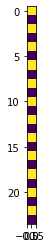

In [5]:
plt.imshow(grouped_conditions_encoded)

In [6]:
grouped_fmri_masked = grouped_fmri_masked * -1

vfwe_neg_log_pvals, csfwe_neg_log_pvals, cmfwe_neg_log_pvals, t_scores_original_data, _, _, _ = permuted_ols(
    grouped_conditions_encoded,
    grouped_fmri_masked,
    # + intercept as a covariate by default
    n_perm=100,
    masker=nifti_masker,
    threshold=0.001,
    two_sided_test=True,
    verbose=1, # display progress bar
    n_jobs=1)  # can be changed to use more CPUs

t_scores_original_data_unmasked = nifti_masker.inverse_transform(
    t_scores_original_data)
signed_vfwe_neg_log_pvals = vfwe_neg_log_pvals * np.sign(t_scores_original_data)
signed_vfwe_neg_log_pvals_unmasked = nifti_masker.inverse_transform(
    signed_vfwe_neg_log_pvals)
signed_csfwe_neg_log_pvals = csfwe_neg_log_pvals * np.sign(t_scores_original_data)
signed_csfwe_neg_log_pvals_unmasked = nifti_masker.inverse_transform(
    signed_csfwe_neg_log_pvals)
signed_cmfwe_neg_log_pvals = cmfwe_neg_log_pvals * np.sign(t_scores_original_data)
signed_cmfwe_neg_log_pvals_unmasked = nifti_masker.inverse_transform(
    signed_cmfwe_neg_log_pvals)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.8s finishedonds remaining)


In [7]:
print(np.where((cmfwe_neg_log_pvals[0, :] != 0) & (np.sign(t_scores_original_data[0, :]) < 0)))
cmfwe_neg_log_pvals

(array([  175,   244,   263, ..., 39904, 39907, 39908]),)


array([[0.00436481, 0.00436481, 0.00436481, ..., 0.00436481, 0.00436481,
        0.00436481]])

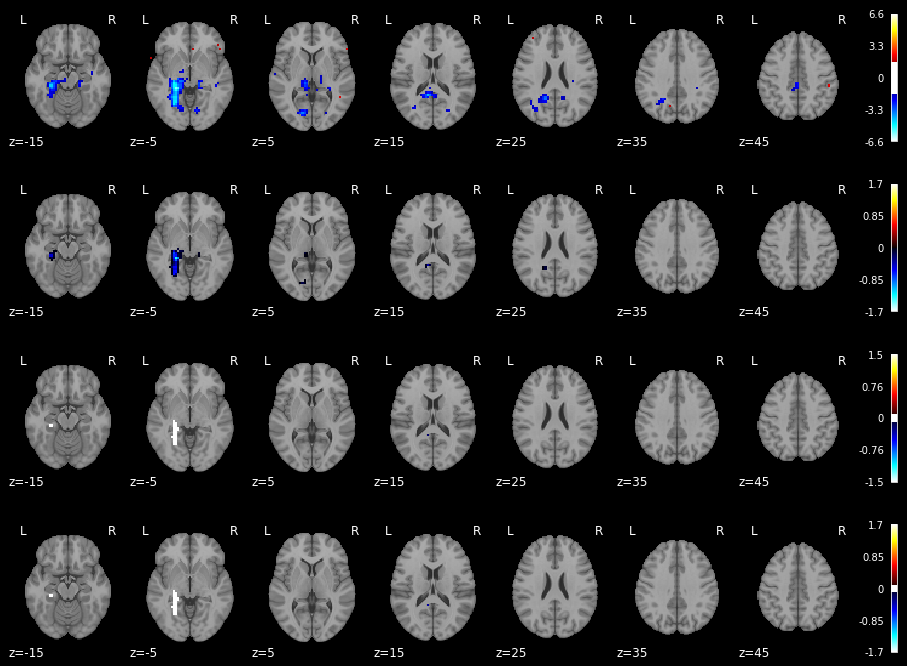

In [10]:
from nilearn.plotting import plot_stat_map, show

# Various plotting parameters
z_slice = 12  # plotted slice

# Plot Anova p-values
fig, axes = plt.subplots(figsize=(16, 12), facecolor='k', nrows=4)

display = plot_stat_map(
    t_scores_original_data_unmasked,
    display_mode='z', 
    figure=fig, 
    axes=axes[0],
    cut_coords=[-15, -5, 5, 15, 25, 35, 45],
    black_bg=True,
    threshold=1.65,
)
display = plot_stat_map(
    signed_vfwe_neg_log_pvals_unmasked,
    display_mode='z', 
    figure=fig, 
    axes=axes[1],
    cut_coords=[-15, -5, 5, 15, 25, 35, 45],
    black_bg=True,
)
display = plot_stat_map(
    signed_csfwe_neg_log_pvals_unmasked,
    display_mode='z', 
    figure=fig, 
    axes=axes[2],
    cut_coords=[-15, -5, 5, 15, 25, 35, 45],
    black_bg=True,
    threshold=0.1,
)
display = plot_stat_map(
    signed_cmfwe_neg_log_pvals_unmasked,
    display_mode='z', 
    figure=fig, 
    axes=axes[3],
    cut_coords=[-15, -5, 5, 15, 25, 35, 45],
    black_bg=True,
    threshold=0.1,
)

In [9]:
print(np.unique(signed_cmfwe_neg_log_pvals_unmasked.get_fdata()))

[-1.69897    -0.537602   -0.37675071 -0.24412514 -0.21467016 -0.00436481
  0.          0.00436481]
